In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Data input and cleaning

In [2]:
import re
sns.set()
data = pd.read_csv("data3.csv", dtype={'time':np.float64})

data['error'] = [float(x[1:-1]) for x in data['fbest']]

def sanitize(data):
    return ''.join(filter(lambda x: x in ',.0123456789', data))

data['history'] = data['fhistorybk'].apply(sanitize)
data['frac'] = data['sol'].str.count("1")/40

data = data.join(data['freq'].str.split(', ', expand=True).apply(pd.to_numeric))

data.drop(["fbest", "freq", "Unnamed: 0", "fhistory", "fhistorybk"], axis=1, inplace=True)
    
data.rename(columns=lambda x: x+1 if type(x)==int else x, inplace=True)

data.describe()

# pd.set_option('display.max_rows', 1000)
# data.sort_values(by=["error"]).drop(['crossover', 'errorLimit', 'nPop', 'time', 'history', 'frac'], axis=1)

,errorLimit,f1,grad,nPop,time,error,frac,1,2,3,4,5,6
count,1.250000e+02,125.000000,125.000000,125.0,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,1.000000e-02,100.000000,150.000000,40.0,3619.988567,46.311145,0.505800,68.617048,251.832067,325.094394,515.203895,746.213154,934.334376
std,6.966817e-18,35.497615,70.995229,0.0,8.669568,26.164479,0.164094,22.272590,92.028079,109.543680,166.310086,246.315518,318.581394
min,1.000000e-02,50.000000,50.000000,40.0,3608.931138,9.132734,0.225000,19.830470,93.117843,121.647403,213.874341,347.449275,465.577394
25%,1.000000e-02,75.000000,100.000000,40.0,3612.831137,28.114571,0.350000,51.264818,175.052278,234.491680,380.755242,533.738150,643.355190
50%,1.000000e-02,100.000000,150.000000,40.0,3618.197577,40.159187,0.525000,74.886976,246.683847,348.031651,535.006627,742.290021,933.854699
75%,1.000000e-02,125.000000,200.000000,40.0,3624.770370,52.779698,0.650000,88.489075,321.698403,415.452205,649.543087,962.150276,1189.525791
max,1.000000e-02,150.000000,250.000000,40.0,3641.217768,96.261367,0.850000,98.742887,432.214808,479.360342,777.194019,1137.963964,1500.420765


In [3]:
errors = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history', 'frac'], axis=1)
errors.drop([x for x in errors.columns if type(x)==int], axis=1, inplace=True)
mean_errors = errors.groupby(["f1", "grad"], as_index=False).mean()

In [4]:
mean_errors = mean_errors.pivot("f1", "grad", "error")
mean_errors

grad,50,100,150,200,250
f1,,,,,
50,92.954306,19.358398,16.501543,28.835767,43.330936
75,93.990960,32.000206,14.695473,18.438447,28.659161
100,94.157175,46.362215,26.376269,25.345895,32.033805
125,92.828644,51.415814,33.717527,36.525270,41.194363
150,93.300052,57.947290,40.549948,45.775254,51.483905


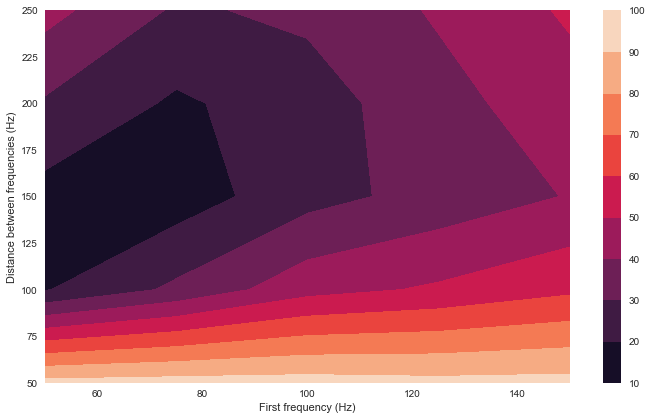

In [9]:
plt.figure(figsize=(10,6))

x = mean_errors.columns.values
y = mean_errors.index.values
Z = mean_errors.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (Hz)")
plt.ylabel("Distance between frequencies (Hz)")
#plt.title("Errors")
plt.colorbar()

plt.tight_layout()
plt.savefig("contour.pgf")
plt.show()

In [6]:
E1 = 3.45e9
E0 = 115e6

p1 = 2950
p0 = 1072.5

L = 0.1

errors_nd = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history'], axis=1)
errors_nd.drop([x for x in errors_nd.columns if type(x)==int], axis=1, inplace=True)
factor = np.sqrt(((E1 - E0) * np.mean(errors_nd['frac']) + E0) / ((p1 - p0) * np.mean(errors_nd['frac']) + p0)) / L
errors_nd['f1'] = errors_nd['f1'] / factor
errors_nd['grad'] = errors_nd['grad'] / factor

errors_nd = errors_nd.drop(['frac'], axis=1)
mean_errors_nd = errors_nd.groupby(["f1", "grad"], as_index=False).mean()
mean_errors_nd = mean_errors_nd.pivot("f1", "grad", "error")

mean_errors_nd.head()

grad,0.005296842837919613,0.010593685675839227,0.015890528513758842,0.021187371351678454,0.02648421418959807
f1,,,,,
0.005297,92.954306,19.358398,16.501543,28.835767,43.330936
0.007945,93.990960,32.000206,14.695473,18.438447,28.659161
0.010594,94.157175,46.362215,26.376269,25.345895,32.033805
0.013242,92.828644,51.415814,33.717527,36.525270,41.194363
0.015891,93.300052,57.947290,40.549948,45.775254,51.483905


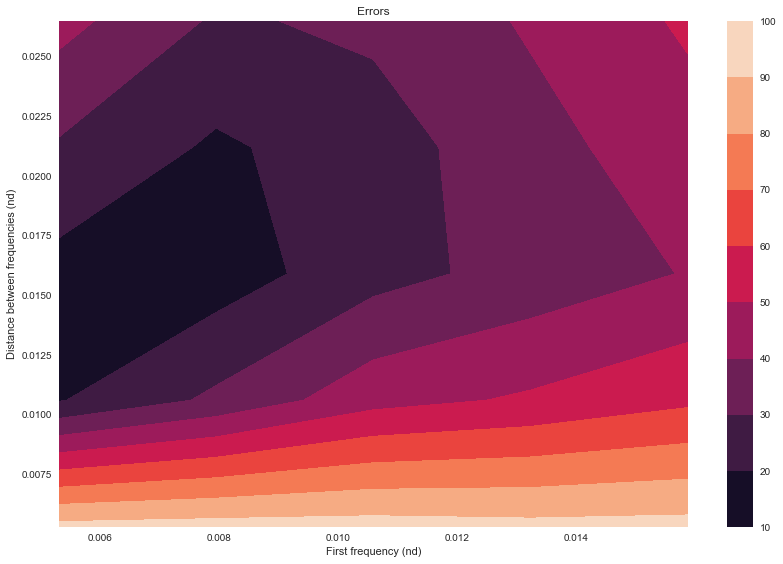

In [7]:
plt.figure(figsize=(12,8))

x = mean_errors_nd.columns.values
y = mean_errors_nd.index.values
Z = mean_errors_nd.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (nd)")
plt.ylabel("Distance between frequencies (nd)")
plt.title("Errors")
plt.colorbar()

plt.tight_layout()
plt.show()

In [8]:
history = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'frac', 'error'], axis=1)
history.drop([x for x in history.columns if type(x)==int], axis=1, inplace=True)
history = pd.concat([history, history['history'].str.split(',', expand=True).apply(pd.to_numeric)], axis=1)
history.drop(["history"], axis=1, inplace=True)
history.head()

,f1,grad,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,50,50,118.387062,118.387062,109.885892,106.132216,106.132216,103.447008,103.447008,103.447008,...,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906
1,50,100,38.773122,38.773122,33.146701,27.023412,27.023412,27.023412,27.023412,27.023412,...,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083
2,50,150,27.234110,27.234110,27.234110,27.234110,23.058660,23.058660,23.058660,23.058660,...,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142
3,50,200,42.899875,40.489248,40.489248,40.489248,40.489248,40.131152,40.131152,40.131152,...,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424
4,50,250,60.395780,60.395780,57.976099,57.976099,57.709084,57.709084,57.709084,55.568792,...,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468
